# Parcours Ingénieur Machine Learning

## Projet 5 : Catégorisez automatiquement des questions

## Import des packages et des données<a class="anchor" id="0"></a>

In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 48kB/s 


In [0]:
#install de glove
!pip install glove_python

     |████████████████████████████████| 266kB 1.4MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700258 sha256=f60853f8b153bbc3fab244e1424a1c5646cd8a9eff182ae7bdf03aa2a37040b9
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
#install de fasttext
!pip install fasttext

     |████████████████████████████████| 61kB 1.1MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2387916 sha256=5de37df197d73827ad053c3e141f5a4ca3999acec34783de6c67a7b39700fa7c
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


In [0]:
#install de BERT
!pip install transformers

     |████████████████████████████████| 573kB 1.4MB/s 
     |████████████████████████████████| 870kB 58.4MB/s 
     |████████████████████████████████| 1.0MB 61.8MB/s 
     |████████████████████████████████| 3.7MB 56.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=5c5717125804831636237d00bd5d1b201f97b5390e13bd1c7793fa54dd10f11f
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 1.4MB/s 


In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc2)


In [0]:
!pip install faiss-gpu

     |████████████████████████████████| 35.5MB 91kB/s 


In [0]:
!pip install -q pyLDAvis

     |████████████████████████████████| 1.6MB 1.4MB/s 
     |████████████████████████████████| 552kB 8.4MB/s 


In [0]:
#import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import pickle
import re
from scipy import sparse

#vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from glove import Glove
import fasttext
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
import torch

#modélisation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import faiss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

#lda
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import spacy

import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

#options
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/export.csv')

print(df.shape)
print(df.head())

(15884, 2)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Title_Body                Tags
0  ['set', 'editor', 'work', 'git', 'windows', 'try', 'git', 'windows', 'get', 'point', 'try', 'git', 'commit', 'get', 'error', 'terminal', 'dum

In [0]:
#On supprime les caractères parasites pour pouvoir binariser notre target
df['Tags_old'] = df['Tags']
df['Title_Body_old'] = df['Title_Body']
char = ["'", "[", "]",","]
for text in char:
    df['Tags'] = df['Tags'].str.replace(text, '')
    df['Title_Body'] = df['Title_Body'].str.replace(text, '')

df = df[df.Tags!='']
df.reset_index(drop=True,inplace=True)

display(df.head())

,Title_Body,Tags,Tags_old,Title_Body_old
0,set editor work git windows try git windows get point try git commit get error terminal dumb visual editor define please supply message use either f option figure need environment variable call editor problem set point notepad work almost default commit message open notepad notepad support bare line feed go get notepad++ figure get notepad++ set editor way work git expect marry notepad++ point mind editor use want able type commit message editor rather command line use git windows tool use edit commit message make work,windows git,"['windows', 'git']","['set', 'editor', 'work', 'git', 'windows', 'try', 'git', 'windows', 'get', 'point', 'try', 'git', 'commit', 'get', 'error', 'terminal', 'dumb', 'visual', 'editor', 'define', 'please', 'supply', 'message', 'use', 'either', 'f', 'option', 'figure', 'need', 'environment', 'variable', 'call', 'editor', 'problem', 'set', 'point', 'notepad', 'work', 'almost', 'default', 'commit', 'message', 'open', 'notepad', 'notepad', 'support', 'bare', 'line', 'feed', 'go', 'get', 'notepad++', 'figure', 'get', 'notepad++', 'set', 'editor', 'way', 'work', 'git', 'expect', 'marry', 'notepad++', 'point', 'mind', 'editor', 'use', 'want', 'able', 'type', 'commit', 'message', 'editor', 'rather', 'command', 'line', 'use', 'git', 'windows', 'tool', 'use', 'edit', 'commit', 'message', 'make', 'work']"
1,angularjs http post send data could anyone tell follow statement send post data designate url url call server print post get empty array print message console add data show correct content http post request url message message also try data string outcome http post request url message + message seem work use follow format http method post url request url data message + message headers content type application x www form urlencoded way http post always include header order work believe content type specify format send data send javascript object,angularjs,['angularjs'],"['angularjs', 'http', 'post', 'send', 'data', 'could', 'anyone', 'tell', 'follow', 'statement', 'send', 'post', 'data', 'designate', 'url', 'url', 'call', 'server', 'print', 'post', 'get', 'empty', 'array', 'print', 'message', 'console', 'add', 'data', 'show', 'correct', 'content', 'http', 'post', 'request', 'url', 'message', 'message', 'also', 'try', 'data', 'string', 'outcome', 'http', 'post', 'request', 'url', 'message', '+', 'message', 'seem', 'work', 'use', 'follow', 'format', 'http', 'method', 'post', 'url', 'request', 'url', 'data', 'message', '+', 'message', 'headers', 'content', 'type', 'application', 'x', 'www', 'form', 'urlencoded', 'way', 'http', 'post', 'always', 'include', 'header', 'order', 'work', 'believe', 'content', 'type', 'specify', 'format', 'send', 'data', 'send', 'javascript', 'object']"
2,correct way create single instance wpf application use c# wpf net rather windows form console correct way create application run single instance know something thing call mutex rarely find someone bother stop explain one code need also inform already run instance user try start second one maybe also pass command line arguments exist,c# net,"['c#', 'net']","['correct', 'way', 'create', 'single', 'instance', 'wpf', 'application', 'use', 'c#', 'wpf', 'net', 'rather', 'windows', 'form', 'console', 'correct', 'way', 'create', 'application', 'run', 'single', 'instance', 'know', 'something', 'thing', 'call', 'mutex', 'rarely', 'find', 'someone', 'bother', 'stop', 'explain', 'one', 'code', 'need', 'also', 'inform', 'already', 'run', 'instance', 'user', 'try', 'start', 'second', 'one', 'maybe', 'also', 'pass', 'command', 'line', 'arguments', 'exist']"
3,build basic python iterator would one create function iterator object python,python,['python'],"['build', 'basic', 'python', 'iterator', 'would', 'one', 'create', 'function', 'iterator', 'object', 'python']"
4,transpose unzip function inverse zip list item tuples like convert list first contain first item tuple second list hold second item example ori

## 1. Approche supervisée : Feature Engineering et modélisation

### 1.1 Transformation de la target "Tags"<a class="anchor" id="1.1"></a>

In [0]:
mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(df['Tags'].str.split(" ")),columns=mlb.classes_)

print(display(y.shape))
print(display(y.head()))

(15879, 36)

None


,android,angularjs,array,asp,bash,c,c#,c++,css,database,file,git,google,html,ios,iphone,java,javascript,jquery,js,linux,mvc,mysql,net,node,objective,php,python,r,rail,ruby,server,sql,string,studio,windows
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


None


In [0]:
y_faiss = df['Tags'].str.split(" ").to_list()

### 1.2 Vectorisation et modélisation

#### 1.2.1 Features Engineering

In [0]:
X = df['Title_Body']

##### 1.2.1.1 CountVectorizer

In [0]:
count_vectorizer = CountVectorizer()

X_CV = count_vectorizer.fit_transform(X)

print(X_CV.shape)

(15879, 15419)


##### 1.2.1.2 TfidfVectorizer

In [0]:
tfidf_vectorizer = TfidfVectorizer()

X_TFIDF = tfidf_vectorizer.fit_transform(X)

print(X_TFIDF.shape)

(15879, 15419)


##### 1.2.1.3 GloVe Embeddings

In [0]:
#Création du modèle Glove : on le joue qu'une fois puis on sauvegarde le modèle

stop = [",", ";", ".", "?", "!", "'", ":", "*", "/", "\n", "(", ")", "|", "_", "`",">","<","=", "$", "%", '"', "[","]","{","}","-"]

lines_without_stopwords=[] 
for line in df['Title_Body'].values: 
    line = line.lower()
    line_by_words = re.split(r'(?:\s+)', line, flags = re.UNICODE)
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

from glove import Corpus, Glove

corpus = Corpus()
glove = Glove(no_components=100, learning_rate=0.05)

corpus.fit(texts, window=10)

glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('/content/drive/My Drive/Colab Notebooks/glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [0]:
#Import du modèle Glove
model_glove = Glove.load('/content/drive/My Drive/Colab Notebooks/glove.model')

vector = {word: model_glove.word_vectors[model_glove.dictionary[word]] for word in model_glove.dictionary.keys()}
X_glove = []

for i in range(0,X.shape[0]):
  phrase = re.split(r'(?:\s+)',X[i])
  feat = sum(vector[w] for w in phrase)
  X_glove.append(feat)

X_glove = np.vstack(X_glove)
X_glove.shape

(15879, 100)

##### 1.2.1.4 FastText Emdeddings

In [0]:
#Création du modèle fasttext
model_fasttext = fasttext.train_unsupervised('/content/drive/My Drive/Colab Notebooks/export.csv')

#Sauvegarde du modèle fasttext
model_fasttext.save_model("/content/drive/My Drive/Colab Notebooks/model_fasttext.bin")

In [0]:
#Chargement du modèle fastext
import fasttext
model_fasttext = fasttext.load_model("/content/drive/My Drive/Colab Notebooks/model_fasttext.bin")

In [0]:
#Features avec Fasttext
def fasttext_features(X, model):
    feats = np.vstack([model.get_sentence_vector(p) for p in X])
    return feats

In [0]:
X_fastext = fasttext_features(X, model_fasttext)
X_fastext.shape

(15879, 100)

##### 1.2.1.5 BERT Embeddings

In [0]:
tokenizer_db = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [0]:
model.cuda()
print("GPU found!")
gpu_detected = 1

GPU found!


In [0]:
content_data_ids = df['Title_Body'].str.slice(0, 500).str.lower().apply(tokenizer_db.encode)

In [0]:
content_data_vectors = []

for cnt_data in content_data_ids:
  input_ids = torch.Tensor(cnt_data).to(torch.int64).unsqueeze(0)
  if gpu_detected == 1:
    outputs = model(input_ids.cuda())
    content_data_vectors.append(outputs[0].detach().cpu().numpy().max(axis = 1))

In [0]:
X_bert = np.vstack(content_data_vectors)

In [0]:
X_bert.shape

(15879, 768)

#### 1.2.2 Réduction de dimension

In [0]:
def simulation_components(X, n_begin, n_end, step):
  var_cum = []

  for components in range(n_begin,n_end,step):
    tsvd = TruncatedSVD(n_components=components)
    X_tsvd = tsvd.fit(X)
    var_cum.append([components,sum(tsvd.explained_variance_ratio_)])

  df_var_cum = pd.DataFrame(var_cum,columns=['n_components','variance'])
  df_var_cum.plot.line('n_components','variance')
  plt.show

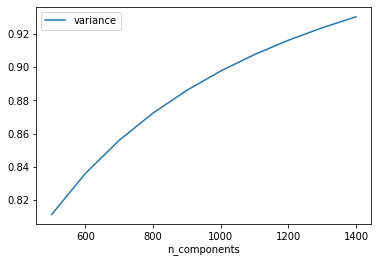

In [0]:
#Count Vectorizer
simulation_components(X_CV, 500, 1500, 100)

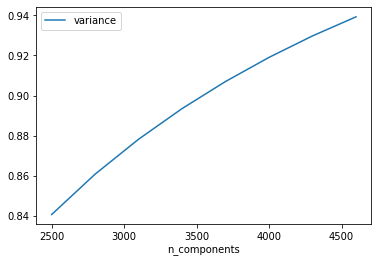

In [0]:
#Tf-Idf
simulation_components(X_TFIDF, 2500, 4900, 300)

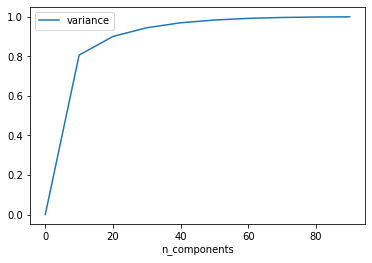

In [0]:
#Glove
simulation_components(X_glove, 0, 100, 10)

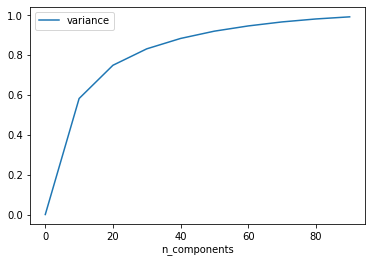

In [0]:
#FastText
simulation_components(X_fastext, 0, 100, 10)

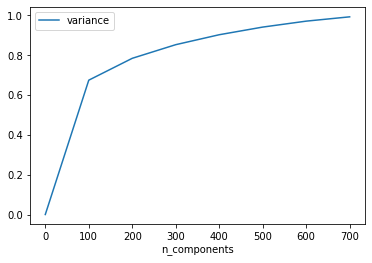

In [0]:
#Bert
simulation_components(X_bert, 0, 800, 100)

#### 1.2.3 Modélisation

In [0]:
lr = LogisticRegression(max_iter=1000)
mnb = MultinomialNB()
xgb = XGBClassifier(tree_method='gpu_exact')
lgbm = LGBMClassifier()
cb = CatBoostClassifier(iterations=100, task_type='GPU', logging_level='Silent')

In [0]:
def play_model(model,vector,n_dim=0):

  start_time = time.time()
  Xtrain, Xtest, ytrain, ytest = train_test_split(vector, y, test_size=0.2, random_state=42)

  if n_dim == 0:
    clf = OneVsRestClassifier(model)
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)

    result.append(metric(ypred, ytest))
    time_score.append((time.time() - start_time))
  
  else:
    tsvd = TruncatedSVD(n_components=n_dim)
    Xtrain_tsvd = tsvd.fit_transform(Xtrain)
    Xtest_tsvd = tsvd.fit_transform(Xtest)

    clf = OneVsRestClassifier(model)
    clf.fit(Xtrain_tsvd, ytrain)
    ypred = clf.predict(Xtest_tsvd)
    
    result.append(metric(ypred, ytest))
    time_score.append((time.time() - start_time))

In [0]:
def metric(ypred, ytest):

  #on insère les prédictions dans un dataframe
  col = ytest.columns.values
  df_ypred = pd.DataFrame(ypred,columns=col)
  df_ytest = ytest.copy().reset_index(drop=True)

  #on compte le nombre d'occurences fausses ligne par ligne
  nb_false = []
  for i in range(0, len(df_ytest)):
    test_row = df_ypred.iloc[i]==df_ytest.iloc[i]
    value = len(test_row) - sum(test_row)
    nb_false.insert(i,value)

  #on ajoute le nombre de tags qui était à estimer
  count_predict_tags = df_ypred.sum(axis=1)
  df_ytest['count_tags'] = df_ytest.sum(axis=1)
  df_ytest['count_predict_tags'] = count_predict_tags
  df_ytest['false_values'] = nb_false

  #on calcule le coefficient ligne par ligne
  score=0
  for i in range(0, len(df_ytest)):
    if df_ytest.iloc[i]['false_values']==0:
      score += 1
    elif (df_ytest.iloc[i]['count_tags']==df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']==3 and df_ytest.iloc[i]['false_values']==1):
      score += 0.75
    elif (df_ytest.iloc[i]['count_tags']==df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']==3 and df_ytest.iloc[i]['false_values']==2):
      score += 0.5
    elif (df_ytest.iloc[i]['count_tags']==df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']==2 and df_ytest.iloc[i]['false_values']==1):
      score += 0.5
    elif (df_ytest.iloc[i]['count_tags']!=df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']+df_ytest.iloc[i]['count_predict_tags']==3 and df_ytest.iloc[i]['false_values']==1):
      score += 0.5
    elif (df_ytest.iloc[i]['count_tags']!=df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']+df_ytest.iloc[i]['count_predict_tags']==4 and df_ytest.iloc[i]['false_values']==2):
      score += 0.25
    elif (df_ytest.iloc[i]['count_tags']!=df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']+df_ytest.iloc[i]['count_predict_tags']==5 and df_ytest.iloc[i]['false_values']==1):
      score += 0.75
    elif (df_ytest.iloc[i]['count_tags']!=df_ytest.iloc[i]['count_predict_tags'] and df_ytest.iloc[i]['count_tags']+df_ytest.iloc[i]['count_predict_tags']==5 and df_ytest.iloc[i]['false_values']==3):
      score += 0.25

  
  return score/len(df_ytest)

In [0]:
def metric_faiss(I, ytrain, ytest):
  ypred = []

  #On récupère les labels prédits
  for i in I:
    labels = []
    for j in range(0, 1):
      labels.append(ytrain[i[j]])
    ypred.append(labels)

  #On retransforme les objets pour les faire passer dans la fonction metric
  ypred = [item for sublist in ypred for item in sublist]

  ytest = pd.DataFrame(mlb.fit_transform(ytest),columns=mlb.classes_)
  ypredtr = mlb.fit_transform(ypred)

  return metric(ypredtr, ytest)

Base Line : android, python, javascript

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_CV, y, test_size=0.2, random_state=42)

cols = ytest.columns

ybaseline = pd.DataFrame(0, index=np.arange(len(ytest)), columns=cols)
ybaseline['android'] = 1
ybaseline['python'] = 1
ybaseline['javascript'] = 1

In [0]:
ybaseline.head()

,android,angularjs,array,asp,bash,c,c#,c++,css,database,file,git,google,html,ios,iphone,java,javascript,jquery,js,linux,mvc,mysql,net,node,objective,php,python,r,rail,ruby,server,sql,string,studio,windows
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


##### **1.2.3.1 Count Vectorizer**

Logisitic Regression, XGBoost, MultinomialNB, Catboost

In [0]:
classifier=[]
result=[]
time_score=[]

Xtrain, Xtest, ytrain, ytest = train_test_split(X_CV, y, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()
classifier.append('base_line')
result.append(metric(ybaseline,ytest))
time_score.append(time.time() - start_time)

In [0]:
classifier.append('mnb')
play_model(mnb,X_CV,0)

In [0]:
classifier.append('lr')
play_model(lr,X_CV,0)

In [0]:
classifier.append('xgb')
play_model(xgb,X_CV,0)

In [0]:
classifier.append('cb')
play_model(cb,X_CV,0)

FAISS

In [0]:
X_CV = X_CV.astype('float32')
Xtrain, Xtest, ytrain, ytest = train_test_split(X_CV, y_faiss, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()

index = faiss.IndexFlatL2(Xtrain.shape[1])
index.add(Xtrain.todense())

k = 1 #nombre de labels
D, I = index.search(Xtest.todense(), k)

classifier.append('faiss')
result.append(metric_faiss(I, ytrain, ytest))
time_score.append((time.time() - start_time))

In [0]:
df_result_cv = pd.DataFrame({'Metric': result,
                             'time' : time_score}, index=classifier)

In [0]:
df_result_cv.to_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_cv.pkl")

##### **1.2.3.2 TF-IDF**

Logistict Regression, XGBoost, MultinomialNB, Catboost

In [0]:
classifier=[]
result=[]
time_score=[]

Xtrain, Xtest, ytrain, ytest = train_test_split(X_TFIDF, y, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()
classifier.append('base_line')
result.append(metric(ybaseline,ytest))
time_score.append(time.time() - start_time)

In [0]:
classifier.append('mnb')
play_model(mnb,X_TFIDF,0)

In [0]:
classifier.append('lr')
play_model(lr,X_TFIDF,0)

In [0]:
classifier.append('xgb')
play_model(xgb,X_TFIDF,0)

In [0]:
classifier.append('cb')
play_model(cb,X_TFIDF,0)

FAISS

In [0]:
X_TFIDF = X_TFIDF.astype('float32')
Xtrain, Xtest, ytrain, ytest = train_test_split(X_TFIDF, y_faiss, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()

index = faiss.IndexFlatL2(Xtrain.shape[1])
index.add(Xtrain.todense())

k = 1 #nombre de labels
D, I = index.search(Xtest.todense(), k)

classifier.append('faiss')
result.append(metric_faiss(I, ytrain, ytest))
time_score.append((time.time() - start_time))

In [0]:
df_result_tfidf = pd.DataFrame({'Metric': result,
                             'time' : time_score}, index=classifier)

In [0]:
df_result_tfidf.to_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_tfidf.pkl")

##### **1.2.3.3 Glove**

Logistic Regression, XGBoost, Catboost

In [0]:
classifier=[]
result=[]
time_score=[]

Xtrain, Xtest, ytrain, ytest = train_test_split(X_glove, y, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()
classifier.append('base_line')
result.append(metric(ybaseline,ytest))
time_score.append(time.time() - start_time)

In [0]:
classifier.append('lr')
play_model(lgbm,X_glove,0)

In [0]:
classifier.append('xgb')
play_model(xgb,X_glove,0)

In [0]:
classifier.append('cb')
play_model(cb,X_glove,0)

FAISS

In [0]:
X_glove = sparse.csr_matrix(X_glove)
X_glove = X_glove.astype('float32')
Xtrain, Xtest, ytrain, ytest = train_test_split(X_glove, y_faiss, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()

index = faiss.IndexFlatL2(Xtrain.shape[1])
index.add(Xtrain.todense())

k = 1 #nombre de labels
D, I = index.search(Xtest.todense(), k)

classifier.append('faiss')
result.append(metric_faiss(I, ytrain, ytest))
time_score.append((time.time() - start_time))

In [0]:
df_result_glove = pd.DataFrame({'Metric': result,
                             'time' : time_score}, index=classifier)

In [0]:
df_result_glove.to_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_glove.pkl")

##### **1.2.3.4 FastText**

Logisitc Regression, XGBoost, Catboost

In [0]:
classifier=[]
result=[]
time_score=[]

Xtrain, Xtest, ytrain, ytest = train_test_split(X_fastext, y, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()
classifier.append('base_line')
result.append(metric(ybaseline,ytest))
time_score.append(time.time() - start_time)

In [0]:
classifier.append('lr')
play_model(lr,X_fastext,0)

In [0]:
classifier.append('xgb')
play_model(xgb,X_fastext,0)

In [0]:
classifier.append('cb')
play_model(cb,X_fastext,0)

FAISS

In [0]:
X_fastext = sparse.csr_matrix(X_fastext)
X_fastext = X_fastext.astype('float32')
Xtrain, Xtest, ytrain, ytest = train_test_split(X_fastext, y_faiss, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()

index = faiss.IndexFlatL2(Xtrain.shape[1])
index.add(Xtrain.todense())

k = 1 #nombre de labels
D, I = index.search(Xtest.todense(), k)

classifier.append('faiss')
result.append(metric_faiss(I, ytrain, ytest))
time_score.append((time.time() - start_time))

In [0]:
df_result_fastext = pd.DataFrame({'Metric': result,
                             'time' : time_score}, index=classifier)

In [0]:
df_result_fastext.to_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_fastText.pkl")

##### **1.2.3.5 BERT**

Logistic Regression, XGBoost, Catboost

In [0]:
classifier=[]
result=[]
time_score=[]

Xtrain, Xtest, ytrain, ytest = train_test_split(X_bert, y, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()
classifier.append('base_line')
result.append(metric(ybaseline,ytest))
time_score.append(time.time() - start_time)

In [0]:
classifier.append('lr')
play_model(lr,X_bert,0)

In [0]:
classifier.append('xgb')
play_model(xgb,X_bert,400)

In [0]:
classifier.append('cb')
play_model(cb,X_bert,0)

FAISS

In [0]:
X_bert = sparse.csr_matrix(X_bert)
X_bert = X_bert.astype('float32')
Xtrain, Xtest, ytrain, ytest = train_test_split(X_bert, y_faiss, test_size=0.2, random_state=42)

In [0]:
start_time = time.time()

index = faiss.IndexFlatL2(Xtrain.shape[1])
index.add(Xtrain.todense())

k = 1 #nombre de labels
D, I = index.search(Xtest.todense(), k)

classifier.append('faiss')
result.append(metric_faiss(I, ytrain, ytest))
time_score.append((time.time() - start_time))

In [0]:
df_result_bert = pd.DataFrame({'Metric': result,
                             'time' : time_score}, index=classifier)

In [0]:
df_result_bert.to_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_bert.pkl")

##### **1.2.3.6 Comparaison des modèles**

In [0]:
df_cv = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_cv.pkl")
df_tfidf = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_tfidf.pkl")
df_glove = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_glove.pkl")
df_fasttext = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_fastText.pkl")
df_bert = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/obj/result_bert.pkl")

In [0]:
list_df = [df_cv, df_tfidf, df_glove, df_fasttext, df_bert]

#On réinitialise l'index
for df in list_df:
  df.index = df.index.set_names(['model'])
  df.reset_index(level=0, inplace=True)

#On ajoute une colonne correspondant au type de vectorisation
df_cv['vector'] = 'CV'
df_tfidf['vector'] = 'TF-IDF'
df_glove['vector'] = 'Glove'
df_fasttext['vector'] = 'FastText'
df_bert['vector'] = 'Bert'

#On concatène tous les dataframes constitués
df_test = pd.concat(list_df)

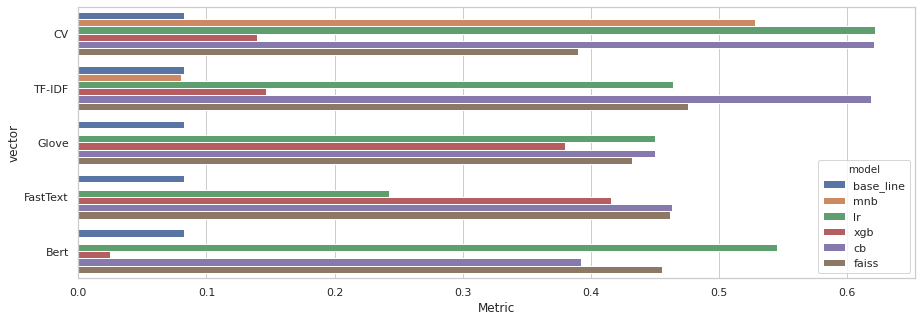

In [0]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 5))

ax = sns.barplot(x="Metric", y="vector", hue="model", data=df_test)

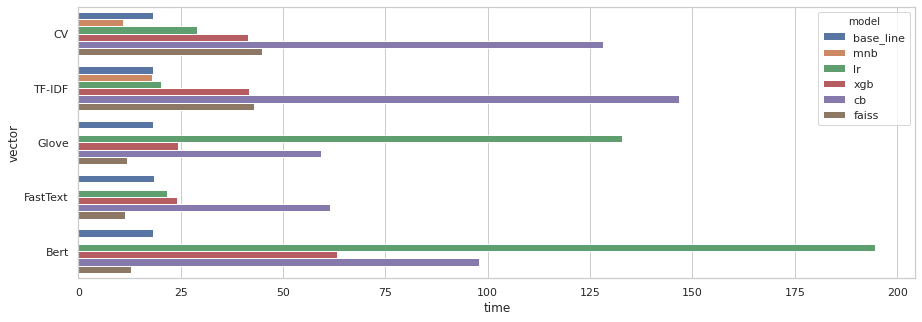

In [0]:
f, ax = plt.subplots(figsize=(15, 5))

ax = sns.barplot(x="time", y="vector", hue="model", data=df_test)

### 1.3 Choix et optimisation du modèle

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_CV, y, test_size=0.2, random_state=42)

In [0]:
# Choix des hyperparamètres du modèle
space = {
        'C': hp.quniform('C', 0.01, 1.0, 0.01),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'solver': hp.choice('solver',['lbfgs','liblinear']),
        'max_iter':1000
    }

def score(params):
    model = LogisticRegression(**params)   
    clf = OneVsRestClassifier(model)
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest).clip(0, 20)
    score = metric(ypred, ytest)*-1
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=100)
    return best

trials = Trials()

In [0]:
best_params = optimize(trials, space)

# Retourne les meilleurs paramètres
space_eval(space, best_params)

-0.6372008816120907
-0.6227172544080605
-0.6170497481108312
-0.6338948362720404
-0.616971032745592
-0.6346819899244333
-0.6139798488664987
-0.6396410579345088
-0.633028967254408
-0.6222449622166247
-0.6241341309823678
-0.6372008816120907
-0.6397197732997482
-0.6388539042821159
-0.6341309823677582
-0.6221662468513854
-0.6213003778337531
-0.6354691435768262
-0.6395623425692695
-0.638617758186398
-0.6394836272040302
-0.6397197732997482
-0.6394836272040302
-0.6396410579345088
-0.6397984886649875
-0.6394836272040302
-0.6395623425692695
-0.6368860201511335
-0.6394836272040302
-0.6196473551637279
-0.6393261964735516
-0.6272827455919395
-0.6358627204030227
-0.6394049118387909
-0.6256297229219143
-0.6362562972292192
-0.6348394206549118
-0.6395623425692695
-0.6257084382871536
-0.6358627204030227
-0.6397197732997482
-0.5702928211586902
-0.6370434508816121
-0.6388539042821159
-0.6353904282115869
-0.608705919395466
-0.6387751889168766
-0.6394049118387909
-0.6394049118387909
-0.6143734256926953
-0.6

{'C': 0.9, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'liblinear'}

In [0]:
model = LogisticRegression(max_iter=1000, C= 0.9, fit_intercept= False, solver = 'liblinear')

In [0]:
clf = OneVsRestClassifier(model)

clf.fit(Xtrain, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=0.9, class_weight=None,
                                                 dual=False,
                                                 fit_intercept=False,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [0]:
#Sauvegarde du modèle
filename = '/content/drive/My Drive/Colab Notebooks/obj/model_lr.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [0]:
#Sauvegarde de la vectorisation
filename = '/content/drive/My Drive/Colab Notebooks/obj/vectorization.pkl'
pickle.dump(count_vectorizer, open(filename, 'wb'))

In [0]:
#Sauvegarde de la binarisation
filename = '/content/drive/My Drive/Colab Notebooks/obj/multiLabBin.pkl'
pickle.dump(mlb, open(filename, 'wb'))

In [0]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(ytest))
pred1 = mlb.inverse_transform(ypred)

comparaison = pd.DataFrame(columns=['Test','Prediction'])

comparaison['Test'] = test1
comparaison['Prediction'] = pred1

comparaison.head(20)

,Test,Prediction
0,"(php, string)","(php,)"
1,"(c#,)",()
2,"(javascript, jquery)","(jquery,)"
3,"(database, sql)","(database,)"
4,"(c,)","(c, linux)"
5,"(git,)","(git,)"
6,"(javascript,)","(javascript,)"
7,"(html, javascript)","(html, javascript)"
8,"(javascript, js, node)",()
9,"(git,)","(git,)"


## 2. Approche non supervisée : Fast LDA

In [0]:
df_lda = pd.DataFrame(df['Title_Body'])

In [0]:
def topics(model, num_topics):
    for id_topic, topic in model.show_topics(formatted=False, num_topics=num_topics, num_words= 10):
        print("******************************************")
        print("Topic %d:" % (id_topic))
        print(" ".join([w[0] for w in topic]))

In [0]:
corpus = []
for i, row in df_lda.iterrows():
    line = row["Title_Body"]
    corpus.append(line)

In [0]:
data_token = [text.split() for text in corpus]

In [0]:
dictionary = Dictionary(data_token)

In [0]:
bow = [dictionary.doc2bow(text) for text in data_token]

In [0]:
perplexity = []
coherence = []

param = [15,20,25,30,35,40]

for n in param:
    model_lda = LdaModel(bow, num_topics=n, id2word=dictionary)
    perplexity.append(model_lda.log_perplexity(bow))
    coherence.append(CoherenceModel(model=model_lda, texts=data_token, dictionary=dictionary, coherence='c_v').get_coherence())

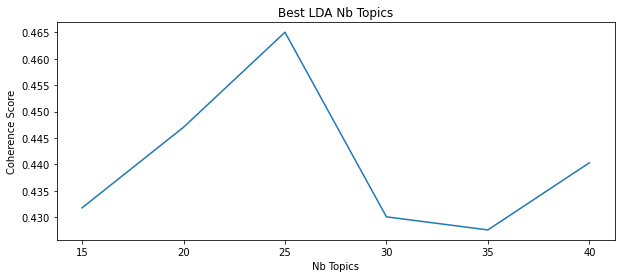

In [0]:
plt.figure(figsize=(10, 4))

plt.plot(param, coherence, label='coherence')

plt.title("Best LDA Nb Topics")
plt.xlabel("Nb Topics")
plt.ylabel("Coherence Score")
plt.show()

In [0]:
ldaModel = LdaModel(bow, num_topics=25, id2word=dictionary)

In [0]:
topics(ldaModel,25)

******************************************
Topic 0:
function jquery + data input form use request javascript post
******************************************
Topic 1:
file py use python get line text mysql window kb
******************************************
Topic 2:
use question would one need understand memory answer read c++
******************************************
Topic 3:
js node python use package install npm module error lib
******************************************
Topic 4:
file html php http server page url use script web
******************************************
Topic 5:
string file foo print list way like python character use
******************************************
Topic 6:
class public static use new get java spring private methods
******************************************
Topic 7:
value object name type json return int string var option
******************************************
Topic 8:
view app android layout ios use button like screen get
************************

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, bow, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.029093  0.053707  1       1        9.498119
10     0.063987  0.028691  2       1        6.765496
16    -0.075913 -0.048577  3       1        5.846984
21     0.098151  0.001485  4       1        5.307807
4      0.147131 -0.017083  5       1        5.231557
3      0.168497 -0.048709  6       1        4.915669
5     -0.027953  0.064540  7       1        4.628577
8     -0.009393 -0.080313  8       1        4.489337
0     -0.000748  0.084897  9       1        4.485039
7     -0.147113  0.081217  10      1        4.347226
12     0.166709 -0.085375  11      1        4.121397
23    -0.139243 -0.133091  12      1        4.100585
6     -0.048108 -0.004021  13      1        4.056480
22     0.005536  0.092981  14      1        3.976054
17    -0.005747  0.076180  15      1        3.834255
13    -0.055685  0.061260  16      1        2.916632
24    -0.150912 -0.292760  17      1        2.861086
20    -0.044537  0.017765  18      1        2.496023
11     0.049950 -0.025731  19      1        2.488285
19     0.020576 -0.012045  20      1        2.431161
15    -0.003705  0.046070  21      1        2.404884
9     -0.099384  0.062486  22      1        2.356437
14    -0.121412  0.129442  23      1        2.317529
1      0.092491  0.059411  24      1        2.266752
18     0.087731 -0.112427  25      1        1.856627, topic_info=        Term         Freq        Total Category  logprob  loglift
274  android  6759.000000  6759.000000  Default  30.0000  30.0000
19   git      3952.000000  3952.000000  Default  29.0000  29.0000
293  file     8015.000000  8015.000000  Default  28.0000  28.0000
86   string   4974.000000  4974.000000  Default  27.0000  27.0000
587  class    5643.000000  5643.000000  Default  26.0000  26.0000
..     ...            ...          ...      ...      ...      ...
50   add      114.589989   3148.408936  Topic25 -5.1460   0.6731 
402  project  105.092529   2164.853516  Topic25 -5.2326   0.9611 
274  android  112.820244   6759.919434  Topic25 -5.1616  -0.1066 
45   want     108.189270   5190.395020  Topic25 -5.2035   0.1157 
48   work     107.397430   5007.705566  Topic25 -5.2109   0.1442 

[1907 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
126   1      0.002893  #         
126   2      0.000482  #         
126   3      0.111365  #         
126   4      0.221766  #         
126   5      0.047728  #         
...  ..           ... ..         
2045  17     0.970557  zygoteinit
5580  10     0.980991  →         
3737  6      0.980152  │         
3738  6      0.981947  └──       
3739  6      0.989445  ├──       

[10818 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 17, 22, 5, 4, 6, 9, 1, 8, 13, 24, 7, 23, 18, 14, 25, 21, 12, 20, 16, 10, 15, 2, 19])

In [0]:
#Sauvegarde du dico
filename = '/content/drive/My Drive/Colab Notebooks/obj/dictionnary.pkl'
pickle.dump(dictionary, open(filename, 'wb'))

In [0]:
#Sauvegarde du modèle LDA
filename = '/content/drive/My Drive/Colab Notebooks/obj/model_lda.pkl'
pickle.dump(ldaModel, open(filename, 'wb'))

## 3. Fonctions de prédiction

In [0]:
import pandas as pd
import numpy as np
from operator import itemgetter
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import re
import nltk
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [0]:
def lower_case(text):
  return text.lower()

def rm_bad_character(text):
  char = [",", ";", ".", "?", "!", "'", ":", "*", "/", "\n", "(", ")", "|", "_", "`",">","<","=", "$", "%", '"', "[","]","{","}","-"]
  dig = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
  for word in char:
    text = text.replace(word,'')
  for num in dig:
    text = text.replace(num,'')
  return text

def rm_stopwords(text):
  stop_list = stopwords.words('english')
  tokenizer = nltk.RegexpTokenizer('\s+', gaps=True)
  doc = tokenizer.tokenize(text)
  words = [item for item in doc if item not in stop_list]
  return ' '.join(words)

def lem(text):
  tokenizer = nltk.RegexpTokenizer('\s+', gaps=True)
  lemmatizer = WordNetLemmatizer()
  doc = tokenizer.tokenize(text)
  words = [lemmatizer.lemmatize(y, pos='v') for y in doc]
  return ' '.join(words)


In [0]:
def cleansing(text):
    text = lower_case(text)
    text = rm_bad_character(text)
    text = rm_stopwords(text)
    text = lem(text)
    return text

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
clf = pickle.load(open('/content/drive/My Drive/Colab Notebooks/obj/model_lr.pkl', 'rb'))
mlb = pickle.load(open('/content/drive/My Drive/Colab Notebooks/obj/multiLabBin.pkl', 'rb'))
vector = pickle.load(open('/content/drive/My Drive/Colab Notebooks/obj/vectorization.pkl', 'rb'))
ldaModel = pickle.load(open('/content/drive/My Drive/Colab Notebooks/obj/model_lda.pkl', 'rb'))
dictionnary = pickle.load(open('/content/drive/My Drive/Colab Notebooks/obj/dictionnary.pkl', 'rb'))

In [0]:
def make_prediction(title,body):
  #on fusionne le title et le body
  full_text = title+' '+body

  #on nettoie notre data
  text_clean = cleansing(full_text)

  #Partie prédiction supervisée
  #on insère notre résultat dans une liste pour effectuer les opérations suivantes
  l = []
  l.append(text_clean)

  #on vectorise
  input_to_pred = vector.transform(l)

  #on passe à la prédiction
  input_pred = clf.predict(input_to_pred)

  #on récupère la ou les valeurs prédites
  output = mlb.inverse_transform(input_pred)

  #Partie prédiction non supervisée
  #création du BOW à partir du dictionnaire
  bow = dictionnary.doc2bow(text_clean.split())

  #on récupère le meilleur topic
  best_topic = max(ldaModel.get_document_topics(bow),key=itemgetter(1))[0]

  #on récupère les 3 premiers keywors
  keywords = [x[0] for x in ldaModel.show_topic(best_topic, topn=3)]

  print(output)
  print(keywords)

In [0]:
body='I have been developing a private python package (my first py package) and want to change the name while retainng all my git commits.I formatted it in a similar way to Cookie Cutter Data Science where all the code lives in the src dir. This has been fine while building but when upload it to a server or another computer I don''t want to have to call it like... from src.data import * I have tried just renaming it using git mv src/ newname/ but when I push this change to Github all my files are lost (i know they are there but I would prefer to easily see all my past changes). I shared it in the form of a .whl file. So do I just have to rename it and deal with loosing the changes? Or is there a different git command to use. Or is there some configuration in the setup.py file i can do? Here is my setup.py for reference.'

In [0]:
title='Change private python package name while retaining git history'

In [0]:
make_prediction(title,body)

[('git',)]
['git', 'branch', 'commit']
